# “数字信号处理”课程设计——工作台

本文件为课程设计项目“语音信号增采样”提供给一个设计、开发和测试的环境。

本文件也属于被评分的部分，学生需要连同课程设计报告一并提交，但请注意以下要求：
- 保留完整的增采样方法的实现代码和输出结果，并进行适当的注释和说明。
- 确保不需要任何改动（例如修改参数），可以全部直接运行和显示结果。
- 删除所有多余的调试代码、无用输出结果等。
- 本文件中可以包含原理说明、结果分析等非编程实现类的内容，但只作为学生自己参考用，教师将仅以课程设计报告中的相关内容作为评分依据。

In [1]:
# Initialization for this notebook.
import numpy as np
from scipy import signal
from scipy import fft
from scipy import interpolate
import matplotlib.pyplot as plt

# Import everything from `lib/dsp.py`.
from lib.dsp import *

# Un-comment the following line to use interactive matplotlib widget.
%matplotlib widget


Bad key text.latex.unicode in file D:\ISC\WPy32-3661\python-3.6.6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file D:\ISC\WPy32-3661\python-3.6.6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file D:\ISC\WPy32-3661\python-3.6.6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://githu

## 引言

以下的代码通过对一组特定信号的频谱分析，引导学生思考如何通过数字滤波的方法实现增采样。

定义一个信号发生函数，用于生成类似语音信号的信号序列。

In [2]:
def gen_signal(fs, n):
    """Generate a test signal that comsists of several sin components."""
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((0.30, 2*np.pi/fs * 1.0e3, 0))
    x_comp.append((0.25, 2*np.pi/fs * 1.5e3, 0))
    x_comp.append((0.20, 2*np.pi/fs * 2.0e3, 0))
    x_comp.append((0.15, 2*np.pi/fs * 2.5e3, 0))
    x_comp.append((0.10, 2*np.pi/fs * 3.0e3, 0))
    
    # Generate the sequence by combining all sin components.
    x = np.sum([seq_sin(A, w, phi, 0, n-1) for A, w, phi in x_comp], axis=0)[0]

    return x

画出三个信号及其频谱：
- 低采样率(8KHz)信号 `x`
- 对 `x` 进行样本间“插零”后的信号 `x_insert_0`
- 目标高采样率(8KHz*6=48KHz)信号 `x_target`

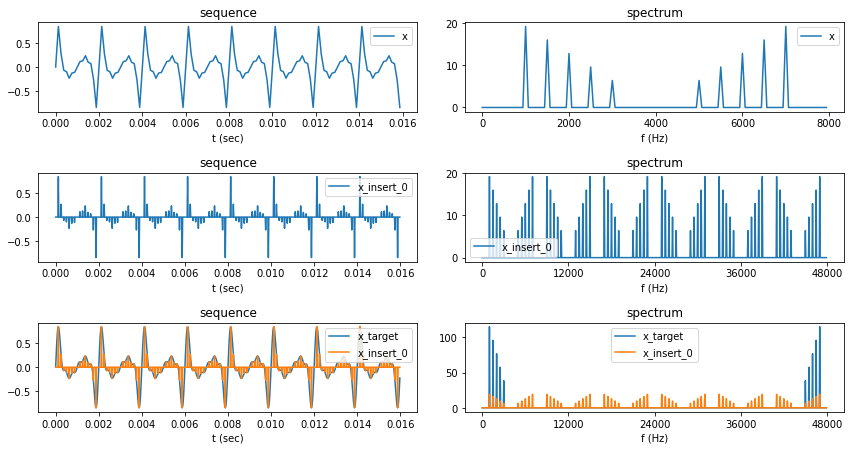

In [3]:
x_len = 128     # length of the low sampling rate signal
fs_x = 8e3      # the low sampling rate 低采样率
up_factor = 6   # upsampling factor 上采样因子

fs_up = fs_x * up_factor
x_len_up = x_len * up_factor

# Generate the low sampling rate signal.
x = gen_signal(fs_x, x_len)

# Insert zeros between samples.
x_insert_0 = np.zeros(x_len_up)
x_insert_0[::up_factor] = x

# Generate a high sampling rate target signal.
x_target = gen_signal(fs_up, x_len_up)

# Plot the signals for inspection.
fig, axs = plt.subplots(3, 2, figsize=(12,6))
fig.tight_layout(h_pad=4)
TITLES = ['sequence', 'spectrum']
plot_signals(['x'], [x], fs_x, axs[0,:], TITLES)
plot_signals(['x_insert_0'], [x_insert_0], fs_up, axs[1,:], TITLES)
plot_signals(
    ['x_target', 'x_insert_0'],
    [x_target, x_insert_0],
    fs_up, axs[2,:],
    TITLES
)

## 基于数字滤波的增采样方法设计

基于以上信号的特点，设计一个基于数字滤波器的增采样方法。

【提示】将低采样率的信号 `x` 通过插零得到 `x_insert_0`，再输入某个数字滤波器后，得到接近目标高采样率信号 `x_target` 的信号 `x_filter`。

请按以下指引，在下文编写程序实现该方法：
- 制定数字滤波器的技术指标。
- 计算满足指标的数字滤波器的系数 `b` 和 `a`。
- 编写一个函数`upsample_filter()`，输入低采样率的信号 `x`，输出通过滤波方法得到的增采样信号 `x_filter`
- 将信号 `x_filter` 与 `x_target` 对齐画在同一个坐标系中进行比较。
  - `x_filter` 相对于 `x_target` 是有延迟，且需要经过一段时间才能达到稳定。因此，需要进行一定的处理才可得到有意义的比较。【提示】截取“有效”部分并对齐。
  通过平移来尽量对齐重叠。
- 计算 `x_filter` 与 `x_target` 有效对齐部分的 MSE（均方差）。
- 尝试不同的滤波器类型和参数，找到最优方案，即 MSE 最小的滤波器及其参数。
  - 至少尝试一种IIR和一种FIR滤波器

## 基于时域插值的增采样方法

查阅资料，学习最近邻域插值(nearest neighbour interpolation)、线性插值(linear interpolation)的基本原理。

【提示】可以利用现成的函数库进行插值计算。

请按以下指引，在下文编写程序实现该方法：
- 编写一个函数 `upsample_interp()`，输入低采样率的信号 `x`，输出通过插值方法得到的增采样信号 `x_interp`。
- 将信号 `x_interp` 与 `x_target` 对齐画在同一个坐标系中进行比较。
  - 注意 `x_interp` 相对于 `x_target` 是否有延迟，是否需要截取“有效”部分并对齐。
- 计算 `x_interp` 与 `x_target` 有效对齐部分的 MSE（均方差）。
- 尝试不同插值类型，找到最优方案，即 MSE 最小插值类型出。

In [4]:
def upsample_interp(x, up_factor, kind='zero'):
    """
    输入低采样率的信号，输出通过指定插值方法得到的增采样信号
    Args:
        x: array, 待插值信号
        up_factor: int, 上采样因子
        kind: str, 默认是 'zero'
            |候选值                 |作用                                                     |
            |'zero', 'nearest'	    |阶梯插值, 相当于零阶 B 样条曲线                            |
            |'slinear', 'linear'	|线性插值, 用一条直线连接所有的取样点, 相当于一阶 B 样条曲线  |
            |'quadratic', 'cubic'	|二阶和三阶 B 样条曲线, 更高阶的曲线可以直接使用整数值指定    |

    Returns:
        x_interp: array, 增采样后序列
    """
    x_len = len(x)
    x_sub = np.linspace(0, x_len, x_len)
    x_len_up = np.linspace(0, x_len, 6 * x_len)
    f_interp = interpolate.interp1d(x_sub, x, kind=kind)
    x_interp = f_interp(x_len_up)
    return x_interp

def gen_comp_plots(x_interp, x_target, fs_up):
    """
    比较增采样结果 x_interp 与目标结果 x_target
    Args:
        x_interp: array, 增采样后的信号
        x_target: array, 目标信号
        fs_up: int, 增采样后的频率
    """
    fig, axs = plt.subplots(3, 2, figsize=(13,7))
    fig.tight_layout(h_pad=3)
    TITLES = ['sequence', 'spectrum']
    plot_signals(['x_interp'], [x_interp], fs_up, axs[0,:], TITLES)
    plot_signals(['x_target'], [x_target], fs_up, axs[1,:], TITLES)
    plot_signals(
        ['x_target', 'x_interp'],
        [x_target, x_interp],
        fs_up, axs[2,:],
        TITLES
    )

def gen_MSE(records_real, records_predict):
    """
    获得均方差
    Args:
        records_real: array, 真实值
        records_predict: array, 目标值
    Returns:
        float, 均方差
    """
    if len(records_real) == len(records_predict):
        return sum(map(lambda x, y: (x - y)**2, records_real, records_predict)) / x_len_up
    else:
        return None

def best_insterp():
    MSEs = {}
    kinds = ('zero', 'nearest', 'slinear', 'linear', 'quadratic', 'cubic')
    for kind in kinds:
        x_interp = upsample_interp(x, up_factor, kind=kind)
        MSEs[kind] = gen_MSE(x_interp, x_target)   

    for key, value in MSEs.items():
        print("\nMethod: " + key)
        print("MSE:    " + str(np.round(value, 4)))

    fig, ax = plt.subplots(figsize=(5, 4))
    i = 0
    for value in MSEs.values():
        ax.scatter(i, value)
        i += 1
    ax.legend(MSEs.keys())
    ax.set_title('MSEs Compare')

## 均方差
均方差（mean square error），用MSE表示。均方差是各数据偏离真实值的距离平方和的平均数，也即误差平方和的平均数，计算公式形式上接近方差，它的开方叫均方根误差，均方根误差才和标准差形式上接近。均方差有时候被认为等同于方差


Method: zero
MSE:    0.1298

Method: nearest
MSE:    0.0484

Method: slinear
MSE:    0.0339

Method: linear
MSE:    0.0339

Method: quadratic
MSE:    0.0362

Method: cubic
MSE:    0.0365


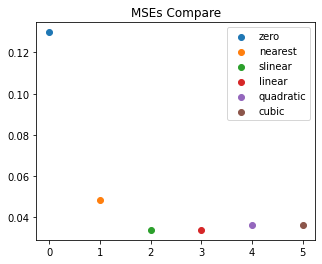

In [5]:
best_insterp()

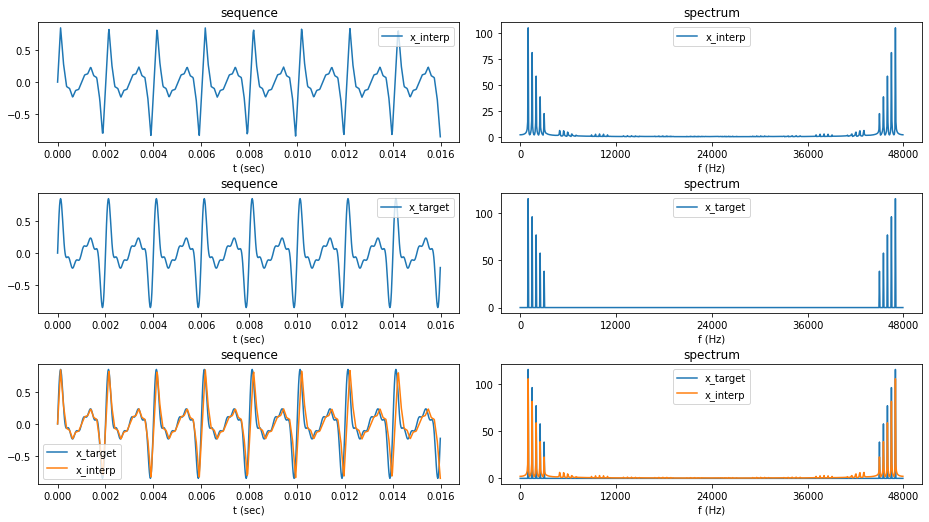

In [6]:
x_interp = upsample_interp(x,up_factor, kind='linear')
gen_comp_plots(x_interp, x_target, fs_up)